In [1]:
import numpy as np
from model import UCCModel
import omegaconf
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from dataset import DatasetTest

In [2]:
def kl_divergence(P, Q):
    return np.mean(np.sum(P*np.log(P/Q), axis=1))


def js_divergence(P, Q):
    m = 0.5 * (P + Q)
    return 0.5 * kl_divergence(P, m) + 0.5 * kl_divergence(Q, m)

In [3]:
# Load Model
output_path = "outputs/2024-03-28/10-18-51/"
model_name = "model_weights.h5"
cfg = omegaconf.OmegaConf.load(os.path.join(output_path, ".hydra\\config.yaml"))

model = UCCModel(cfg)
model.build(input_shape=())
model.load_weights(filepath=os.path.join(output_path, model_name))

In [4]:
def kde(data, sigma=0.1, num_nodes=11,  num_features=None):
    batch_size, num_features = data.shape
    # our input data shape is batchsize x bins
    # we want each linspace to represent a distribution for each feature of each instance. Expected shape = [batch_size, num_nodes]
    k_sample_points = tf.constant(
        np.tile(np.linspace(0, 1, num=num_nodes), [batch_size, 1]).astype(np.float32))
    k_alpha = tf.constant(
        np.array(1/np.sqrt(2*np.pi*np.square(sigma))).astype(np.float32))
    k_beta = tf.constant(
        np.array(-1/(2*np.square(sigma))).astype(np.float32))
    out = []
    # for concatenating across each feature point
    for i in range(num_features):
        # For each feature point
        # Reshape for broadcasting
        
        temp = tf.reshape(
            data[:, i], (batch_size, 1))
        # get x-x_0 values into a grid
        k_diff = k_sample_points - tf.tile(temp, [1, num_nodes])
        diff_sq = tf.square(k_diff)
        k_result = k_alpha * tf.exp(k_beta*diff_sq)
        # add all the feature values across instances. Expected shape = [batch_size, num_nodes]
        k_out_unnormalized = tf.reduce_sum(k_result, axis=0)
        k_norm_coeff = tf.reshape(tf.reduce_sum(
            k_out_unnormalized, axis=0), (-1, 1))
        k_out = k_out_unnormalized / k_norm_coeff
        out.append(tf.reshape(k_out, [1, num_nodes]))
    # Expected output shape =[batch_size,num_features, num_nodes]
    concat_out = tf.concat(out, axis=0)
    return concat_out

In [5]:
# def js_divergence(p,q):
# 	m = 0.5*(p+q)
# 	log_p_over_m = np.log2(p/m)
# 	log_q_over_m = np.log2(q/m)

# 	return 0.5*np.sum(p*log_p_over_m) + 0.5*np.sum(q*log_q_over_m)

splitted_dataset = np.load("../data/mnist/splitted_mnist_dataset.npz")
x_test = splitted_dataset['x_test']
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],x_test.shape[2],1))
x_test = (x_test - np.mean(x_test, axis=(0,1,2)))/ np.std(x_test, axis=(0,1,2))
y_test = splitted_dataset['y_test']
feature_distribution_dict = dict()
for i in range(0,10):
    indices = np.where(y_test == i) 
    inputs = x_test[indices]
    data = []
    for k in range(inputs.shape[0]):
        data.append(model.encoder(inputs[i].reshape([1, inputs.shape[1], inputs.shape[2], inputs.shape[3]])))
    data = tf.concat(data, axis=0)
    feature_distribution= kde(data)
    print(feature_distribution.shape)
    feature_distribution_dict[f"{i}"] = feature_distribution.numpy()

js_divergence_array = np.zeros((10,10))
for i in range(10):
    p_array = feature_distribution_dict[f'{i}']
    # p_array = feature_distribution_dict[f'{i}'].flatten()
    p = np.clip(p_array, 1e-12,1)
    for k in range(i, 10):
        q_array = feature_distribution_dict[f'{k}']
        # q_array = feature_distribution_dict[f'{k}'].flatten()
        q = np.clip(q_array, 1e-12, 1)
        js_divergence_array[i,k] = js_divergence(p,q)
        js_divergence_array[k,i] = js_divergence_array[i,k]

(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)
(10, 11)


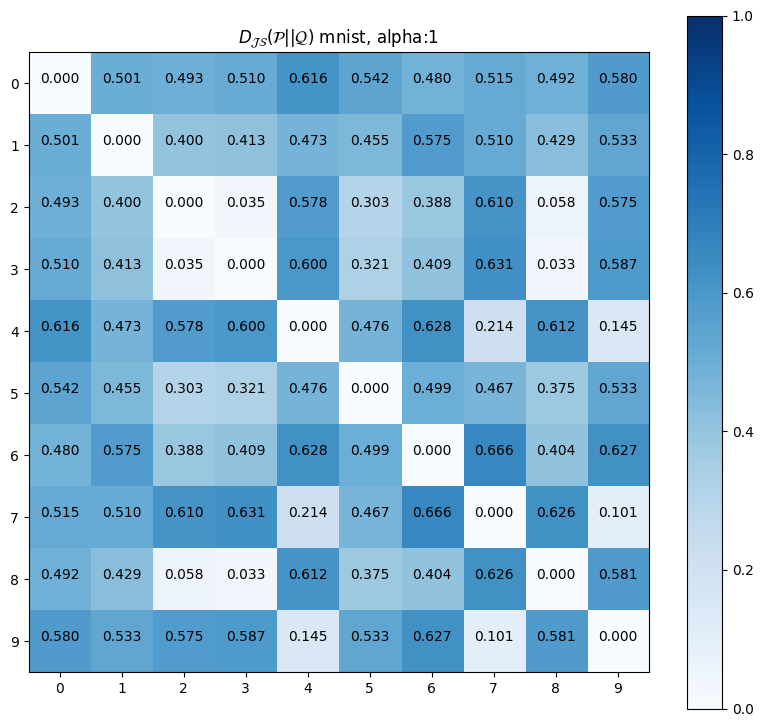

In [6]:
import matplotlib.pyplot as plt
import itertools
classes = ['0','1','2','3','4','5','6','7','8','9']
fig = plt.figure(figsize=(10,9))
plt.imshow(js_divergence_array, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1 )
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.title('$D_{\mathcal{JS}}(\mathcal{P}||\mathcal{Q})$'+f" {cfg.args.dataset}, alpha:{cfg.model.loss.alpha}")

plt.xticks(tick_marks, classes, rotation=0)
plt.yticks(tick_marks, classes)
fmt = '.3f'
for m, n in itertools.product(range(js_divergence_array.shape[0]), range(js_divergence_array.shape[1])):
    plt.text(n, m, format(js_divergence_array[m, n], fmt),
                horizontalalignment="center",
                color="black")

fig_filename = output_path + f'{cfg.args.dataset}_JS_divergence.png'
fig.savefig(fig_filename, bbox_inches='tight')

In [7]:
def plot_confusion_matrix(cm, classes,
						  normalize=False,
						  title='Confusion matrix',
						  cmap=plt.cm.Blues):
	"""
	This function prints and plots the confusion matrix.
	Normalization can be applied by setting `normalize=True`.
	"""
	if normalize:
		cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
		print("Normalized confusion matrix")
	else:
		print('Confusion matrix, without normalization')

	# print(cm)

	plt.imshow(cm, interpolation='nearest', cmap=cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation=0)
	plt.yticks(tick_marks, classes)

	fmt = '.3f' if normalize else 'd'
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, format(cm[i, j], fmt),
				 horizontalalignment="center",
				 color="white" if cm[i, j] > thresh else "black")

	plt.ylabel('True label')
	plt.xlabel('Predicted label')
	plt.tight_layout()


# Confusion matrix 


labels_list = []
pred_list = []
dataset = DatasetTest(
    num_instances=cfg.args.num_instances,
    num_samples_per_class=cfg.args.num_samples_per_class,
    digit_arr=range(0,10),
    ucc_start=cfg.args.ucc_start,
    ucc_end=cfg.args.ucc_end,
)
# doing 10k dataset
for i in range(500):
    inputs, labels = dataset.next_batch_test()
    pred = model.ucc_model(inputs=inputs)
    labels_list.append(labels)
    pred_list.append(pred)

pred_list = tf.concat(pred_list, axis=0)
labels_list = tf.concat(labels_list, axis=0)
labels_list = tf.argmax(labels_list, axis=1)
pred_list = tf.argmax(pred_list, axis=1)




x_test shape: (10000, 28, 28, 1)
10000 test samples
y_test shape: (10000,)
digit0:0, num_test:980
digit1:1, num_test:1135
digit2:2, num_test:1032
digit3:3, num_test:1010
digit4:4, num_test:982
digit5:5, num_test:892
digit6:6, num_test:958
digit7:7, num_test:1028
digit8:8, num_test:974
digit9:9, num_test:1009


In [8]:
acc = tf.metrics.Accuracy()
ucc_accuracy = acc(labels_list, pred_list)

In [9]:
ucc_accuracy

<tf.Tensor: shape=(), dtype=float32, numpy=0.996>

[[2500    0    0]
 [  21 2475    4]
 [   5    0 2495]]
Normalized confusion matrix


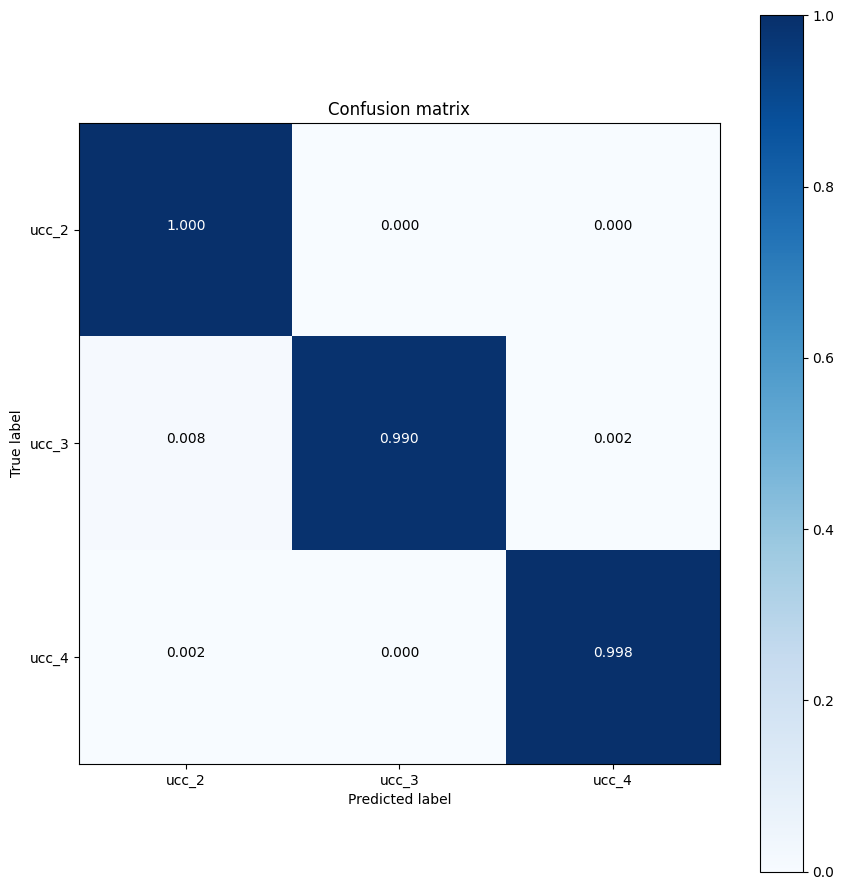

In [10]:
confusion_matrix = tf.math.confusion_matrix(labels=labels_list, predictions=pred_list).numpy()
print(confusion_matrix)
class_names = [f"ucc_{i}" for i in range(cfg.args.ucc_start, cfg.args.ucc_end+1)]
fig1 = plt.figure(figsize=(9,9))
plot_confusion_matrix(confusion_matrix, classes=class_names, normalize=True, title='Confusion matrix')
fig_filename = output_path + f'{cfg.args.dataset}_test_confusion_matrix_normalized.png'
fig1.savefig(fig_filename, bbox_inches='tight')

In [11]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import metrics
from time import time

def cluster(estimator=None, name=None, data=None, labels=None):
	t0 = time()
	estimator.fit(data)
	homogeneity_score = metrics.homogeneity_score(labels, estimator.labels_)
	completeness_score = metrics.completeness_score(labels, estimator.labels_)
	v_measure_score = metrics.v_measure_score(labels, estimator.labels_)
	adjusted_rand_score = metrics.adjusted_rand_score(labels, estimator.labels_)
	adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(labels,  estimator.labels_)
	normalized_mutual_info_score = metrics.normalized_mutual_info_score(labels, estimator.labels_)

	print('%-9s\t%.2fs\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'% (name,
														(time() - t0),
														homogeneity_score,
														completeness_score,
														v_measure_score,
														adjusted_rand_score,
														adjusted_mutual_info_score,
														normalized_mutual_info_score
														))

	clustering_scores = np.array([homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score]).reshape((1,-1))
	return clustering_scores


s_estimator = SpectralClustering(n_clusters=10, eigen_solver='arpack', affinity="nearest_neighbors")
k_estimator = KMeans(n_clusters=10, init='k-means++', n_init=10)
features = []
for i in range(int(x_test.shape[0]/500)):
	inputs = x_test[i*500:(i+1)*500, :, :, :]
	feature = model.encoder(inputs)
	features.append(feature)
features = np.concatenate(features, axis=0)
print(features.shape)
s_predicted_labels_arr = cluster(estimator=s_estimator, data=features, labels=y_test)
k_predicted_labels_arr = cluster(estimator=k_estimator, data=features, labels=y_test)

with open(os.path.join(output_path, "clustering-accuracy.txt"), "w") as file:
	file.writelines("model\t homogeneity\t completeness\t v_measure\t adjusted_rand_score\t adjusted_mutual_info_score\t normalized_mutual_info_score\n")
	file.writelines(f"Spectral\t{np.around(s_predicted_labels_arr, 3)}\n")
	file.writelines(f"Kmeans\t {np.around(k_predicted_labels_arr, 3)}\n")

(10000, 10)
None     	6.15s	0.812	0.889	0.849	0.634	0.849	0.849
None     	0.25s	0.871	0.915	0.892	0.818	0.892	0.892


In [12]:
s_predicted_labels_arr.squeeze()

array([0.81226146, 0.88917548, 0.84898   , 0.63353   , 0.84870088,
       0.84898   ])

In [13]:
print(s_estimator)

SpectralClustering(affinity='nearest_neighbors', eigen_solver='arpack',
                   n_clusters=10)
